In [21]:
# change the global options that Geopandas inherits from
pd.set_option('display.max_columns',None)
import os
import geopandas as gpd
import config as conf
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import copy
import matplotlib.pyplot as plt
import util_functions as ut
import gc

cwd = os.getcwd()

Read successful


In [83]:
#%% input: source node, list of candidate nodes; output: 
def get_nearest(src_point, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_point, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)

In [18]:
streets.FCC.unique().tolist()

FCC_roadclass_dict = {'A31':'secondary', 'A41':'local', 'A33':'secondary', 'A32':'secondary', 'A61':'local', 'A42':'local', 'A74':'local',
            'A63':'local', 'A62':'local', 'A21':'highway', 'A11':'highway', 'A64':'local', 'A99':'local', 'A71':0, 'A72':0, 'A73':0, 'H10':0}
roadclass_frc_map = {'highway':2, 'secondary':3, 'local':4, 0:0}
streets['frc'] = streets['FCC'].map(FCC_roadclass_dict).map(roadclass_frc_map).astype(int)
streets['frc'].unique()

array([3, 4, 0, 2])

In [11]:
streets[streets['FCC'].isin(['A11'])]['ST_NAME'].unique()

array(['I279 HOV', 'I279', 'I376 BUS EB', 'I376 BUS WB', 'I376',
       'I376 EB', 'I76', 'I79', 'FORT DUQUESNE', 'PA TPK 576', 'I579'],
      dtype=object)

In [22]:
streets_shapefile_path = os.path.join(cwd, 'Data', 'Input_Data', 'AlleghenyCounty_StreetCenterlines202208', 
                                     'AlleghenyCounty_StreetCenterlines202208.shp')
bikemap_folder = os.path.join(cwd, 'Data', 'Input_Data', 'bike-map-2019')
studyarea_filepath = os.path.join(cwd, 'Data', 'Output_Data', 'study_area.csv')
crash_path = os.path.join(cwd, 'Data', 'Input_Data','df_crash.csv')


streets = gpd.read_file(streets_shapefile_path)
streets.to_crs('epsg:4326', inplace=True)
study_area_gdf = gpd.read_file(studyarea_filepath)
# #%% TODO: try this new way where you buffer the study area by x miles
# x = conf.config_data['Geography']['buffer']  # miles
# # this is a buffered study area
# study_area_gdf = study_area_gdf.to_crs(crs='epsg:32128').buffer(x*1609).to_crs('EPSG:4326')  # 1609 meters/mile

streets_clip = gpd.clip(streets, study_area_gdf).reset_index()

# clean the data: 
    # 1) remove pedestrian only ('A71', 'A72'), streams (H10), and alleys (A73)
    # 2) rename twoway streets from None to 'Both'
    # 3) record length of line
streets_clip = streets_clip[~streets_clip.FCC.isin(['A71', 'A72', 'A73', 'H10'])].reset_index(drop=True)
streets_clip['ONEWAY'].fillna(value='Both', inplace=True) 
#streets_clip['length_gcd'] = streets_clip['geometry'].apply(lambda x: calc_gcd_line(x))
streets_clip.to_crs(crs='epsg:32128', inplace=True)
streets_clip['length_meters'] = streets_clip.geometry.length

# map road class to frc for compatibility with inrix
FCC_roadclass_dict = {'A31':'secondary', 'A41':'local', 'A33':'secondary', 'A32':'secondary', 'A61':'local', 'A42':'local', 'A74':'local',
            'A63':'local', 'A62':'local', 'A21':'highway', 'A11':'highway', 'A64':'local', 'A99':'local', 'A71':0, 'A72':0, 'A73':0, 'H10':0}
roadclass_frc_map = {'highway':2, 'secondary':3, 'local':4, 0:0}
streets_clip['frc'] = streets_clip['FCC'].map(FCC_roadclass_dict).map(roadclass_frc_map).astype(int)
streets_clip['frc'].unique()


#%% Vehicle safety
# add vehicle crash data
# read last two years of crash data (see: download_crash_data)
# df_crash_2020 = pd.read_csv(crash_yr0_path)
# df_crash_2019 = pd.read_csv(crash_yr1_path) 
# df_crash = pd.concat([df_crash_2019, df_crash_2020], ignore_index=True)
# del df_crash_2020
# del df_crash_2019
# cols_keep = ['DEC_LAT', 'DEC_LONG', 'BICYCLE', 'BICYCLE_COUNT', 'PEDESTRIAN', 'PED_COUNT', 
#             'SPEED_LIMIT', 'VEHICLE_COUNT', 'TOT_INJ_COUNT']
# df_crash = df_crash[cols_keep]
# Remove rows that do not have both a lat and long populated

# Vehicle safety: add vehicle crash data
df_crash = pd.read_csv(crash_path)
df_crash = df_crash.loc[~((df_crash['DEC_LAT'].isnull()) | (df_crash['DEC_LONG'].isnull()))]
gdf_crash = gpd.GeoDataFrame(df_crash, geometry=gpd.points_from_xy(x=df_crash['DEC_LONG'], y=df_crash['DEC_LAT']), 
                            crs='EPSG:4326')
del df_crash
gc.collect()
gdf_crash_clip = gpd.clip(gdf_crash, study_area_gdf)  # clip to neighborhood mask

# Separate crashes by bike, pedestrian, vehicle
#gdf_ped_crash = gdf_crash_clip.loc[gdf_crash_clip.PEDESTRIAN >= 1]  # pedestrian crashes
gdf_bike_crash = gdf_crash_clip.loc[gdf_crash_clip.BICYCLE >= 1]  # bicycle crashes
gdf_veh_crash = gdf_crash_clip.loc[gdf_crash_clip.VEHICLE_COUNT >= 1]  # vehicle crashes

streets_clip.to_crs(crs='epsg:3857', inplace=True)
gdf_veh_crash.to_crs(crs='epsg:3857', inplace=True)
crash_edges = gdf_veh_crash.sjoin_nearest(streets_clip, how='left')#, distance_col = 'Distance')
crash_grouped = crash_edges.groupby(['OBJECTID_1']).agg({
    'TOT_INJ_COUNT':['sum','count']}).reset_index()
crash_grouped.columns = ['OBJECTID_1','tot_inj_sum', 'crash_count']
# this checks out: we see that I375 has the most crashes over the last 2 years (>100)
streets_clip = pd.merge(streets_clip, crash_grouped, on='OBJECTID_1', how='left')
cols_keep = ['OBJECTID_1', 'ST_NAME', 'ONEWAY', 'geometry', 'SPEED', 'length_meters', 'tot_inj_sum', 'crash_count']

#%% Bike safety
# join all bikelane shapefiles together. record which type of bikelane (i.e. protected, trail, etc.)
bikemap_folder = bikemap_folder

# the WPRDC website provides different GIS files for each bikeway types. here we will concatenate them into one gdf 
# note: we will add trails separately because they are off-road and not included in street centerline file
bikeway_type = ['Bike Lanes', 'On Street Bike Route', 'Protected Bike Lane',
                'Bridges', 'Bikeable_Sidewalks', 'Cautionary Bike Route']
gdf_bikeway = gpd.GeoDataFrame()
for b in bikeway_type:
    new_path = os.path.join(bikemap_folder, b)
    filename = b + '.shp'
    gdf =  gpd.read_file(os.path.join(new_path, filename))
    gdf['bikeway_type'] = b
    cols_keep = ['geometry','bikeway_type']
    gdf = gdf[cols_keep]
    gdf_bikeway = pd.concat([gdf_bikeway, gdf])
# clip to the study area (need to change crs)
gdf_bikeway.to_crs(crs=4326, inplace=True) 
gdf_bikeway = gpd.clip(gdf_bikeway, study_area_gdf)
gdf_bikeway.reset_index(inplace=True)
# buffer the line and set as new geom. change crs to buffer by meter value 
gdf_bikeway.to_crs(crs=3857, inplace=True)
gdf_bikeway['geometry_buffer'] = gdf_bikeway.geometry.buffer(20)
gdf_bikeway.set_geometry('geometry_buffer', inplace=True)
gdf_bikeway.drop(columns=['index'], inplace=True)
gdf_bikeway['bikelane_id'] = gdf_bikeway.index

# spatially join bikeway to streets_clip. change crs for spatial join
streets_clip.to_crs(crs=3857, inplace=True)
# use left join so that all streets are accounted for 
streets_clip = streets_clip.sjoin(gdf_bikeway, how='left', predicate='within')
streets_clip = gpd.GeoDataFrame(streets_clip).reset_index().rename(columns = {'geometry_left':'geometry','geometry_right':'geometry_bikelane'}).drop(columns=['geometry_bikelane'])
#streets_clip.set_geometry('geometry_street', inplace=True)
streets_clip['bikeway_type'].fillna(value='None', inplace=True)

# drop duplicates by OBJECTID_1 based on hierarchy for bikeway_type
bike_hierarchy = {'Protected Bike Lane':0, 'Bike Lanes':1, 'On Street Bike Route':2, 
                'Cautionary Bike Route':3, 'Bikeable_Sidewalks':4, 'None':5}
streets_clip['bikeway_type_num'] = streets_clip['bikeway_type'].map(bike_hierarchy)

streets_clip = streets_clip.sort_values(['OBJECTID_1', 'bikeway_type_num']).drop_duplicates(['OBJECTID_1'])

#%%
cols_keep = ['OBJECTID_1', 'ST_NAME', 'ONEWAY', 'geometry', 'length_meters', 'SPEED', 'tot_inj_sum', 'crash_count',
            'bikeway_type', 'bikelane_id']
streets_clip = streets_clip[cols_keep]
streets_clip.columns = ['id', 'st_name', 'oneway', 'geometry', 'length_m', 'speed_lim', 'tot_inj_sum', 'crash_count', 'bikeway_type', 'bikelane_id']
streets_clip['crash_count'].fillna(value=0, inplace=True) 
streets_clip['tot_inj_sum'].fillna(value=0, inplace=True) 
streets_clip.reset_index(inplace=True, drop=True)

# add drive risk idx and bike risk idx
# 1) drive risk: depends only on crash; 2) bike risk: depends on bike infrastructure
streets_clip.loc[:,'crash_per_meter'] = (streets_clip['crash_count'] / streets_clip['length_m'])
streets_clip.loc[:,'risk_idx_drive'] = 1 + conf.config_data['Risk_Parameters']['crash_weight'] * streets_clip['crash_per_meter']
streets_clip['risk_idx_bike'] = streets_clip.apply(lambda row: ut.calc_bike_risk_index(row), axis=1)

/home/lgraff/ENTER/envs/py39/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/lgraff/ENTER/envs/py39/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [23]:
streets_clip.columns
cols_keep = ['id', 'st_name', 'oneway', 'geometry', 'length_m', 'speed_lim']

Index(['id', 'st_name', 'oneway', 'geometry', 'length_m', 'speed_lim',
       'tot_inj_sum', 'crash_count', 'bikeway_type', 'bikelane_id',
       'crash_per_meter', 'risk_idx_drive', 'risk_idx_bike'],
      dtype='object')

1750


<AxesSubplot: >

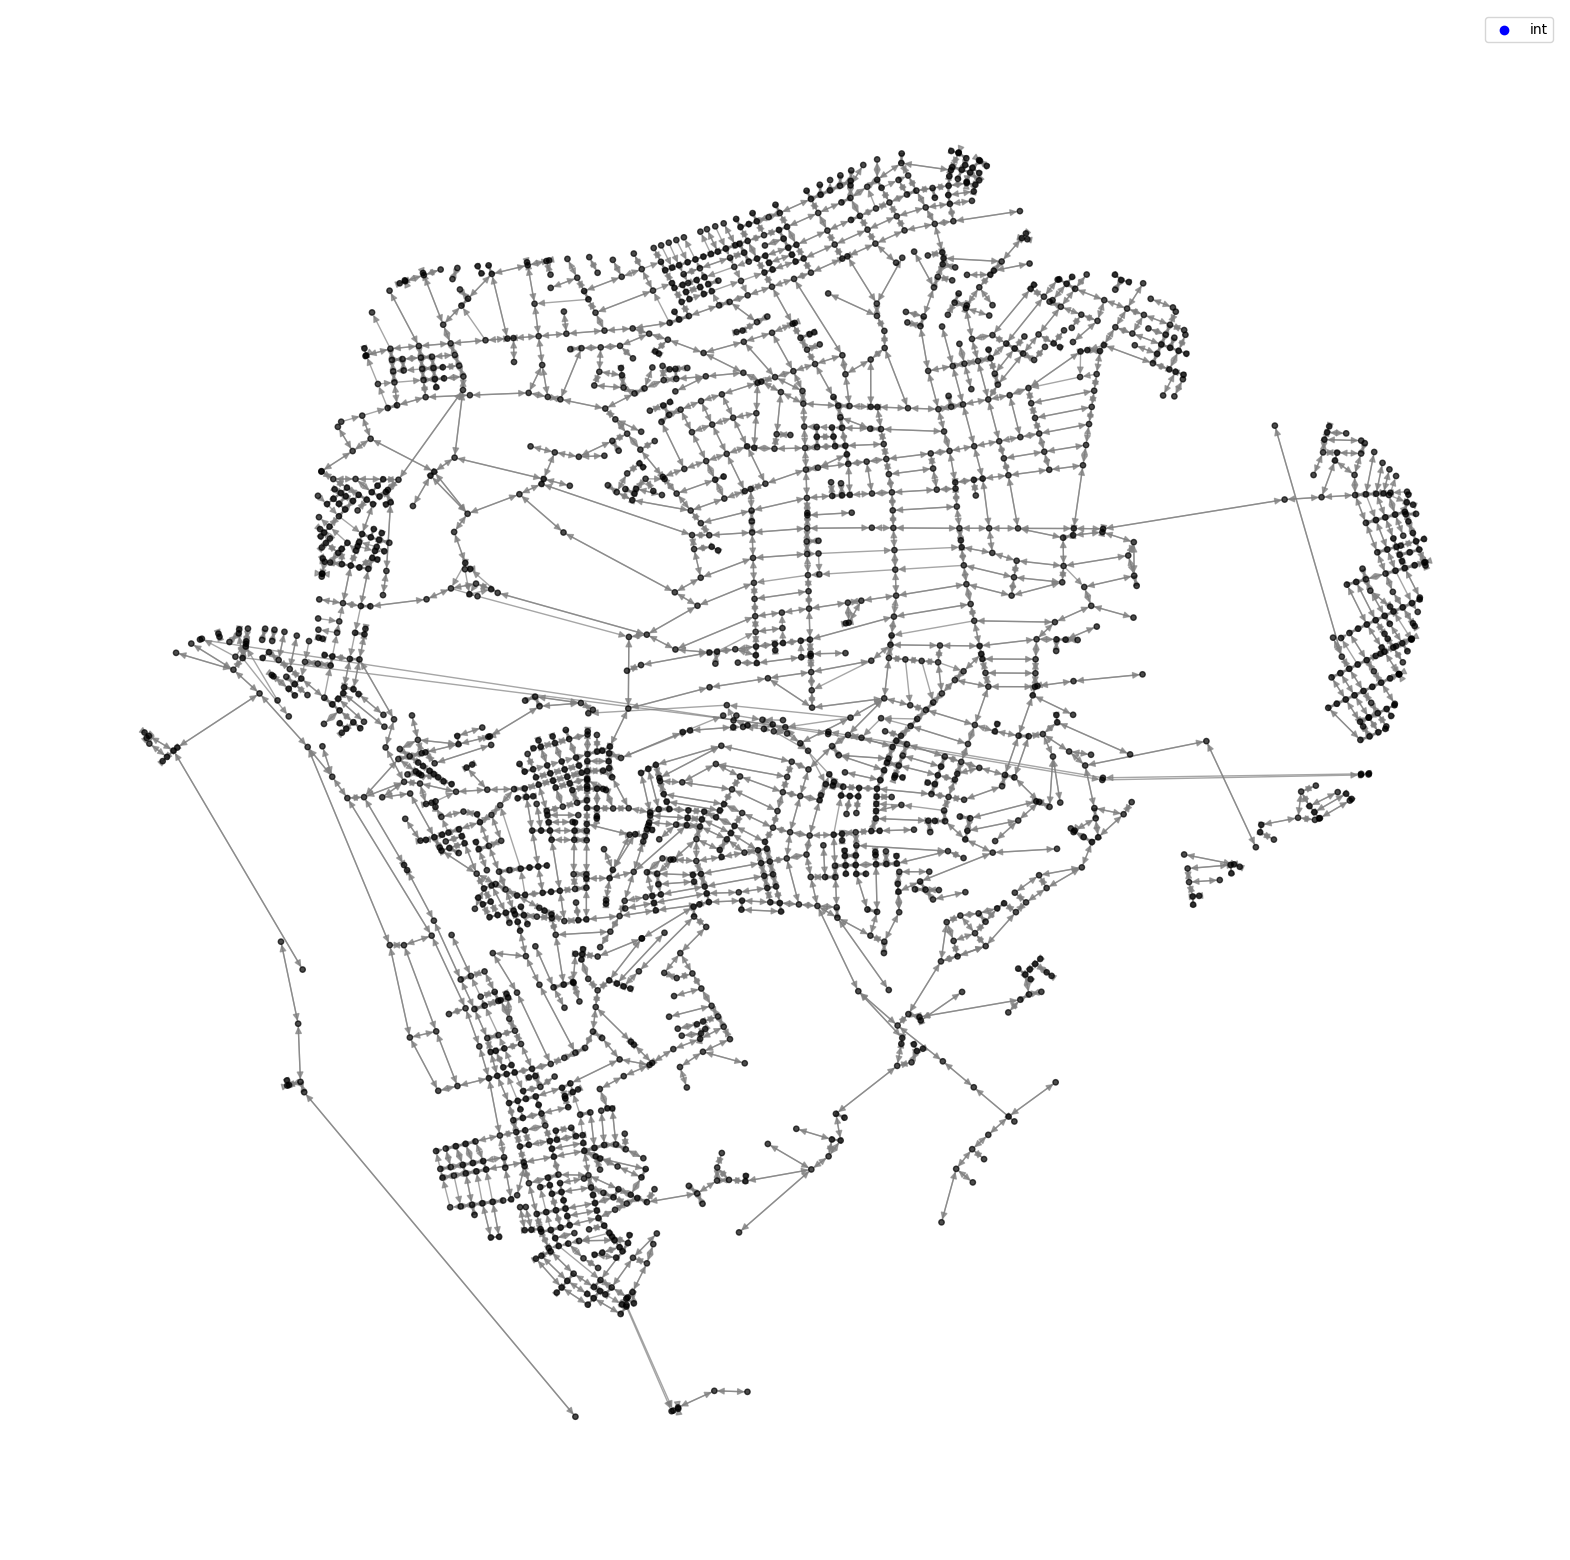

In [24]:
nodes_set = set()
edges = dict()

# first establish the nodes along with their IDs by choosing the endpoints of the linestrings
streets_clip.to_crs('4326', inplace=True)
for line in streets_clip.geometry:
    try:
        endpoints = line.boundary.geoms
        nodes_set.add((endpoints[0].x, endpoints[0].y))
        nodes_set.add((endpoints[1].x, endpoints[1].y))
    except:
        pass

# convert to gdf
nodes_df = pd.DataFrame(list(nodes_set), columns=['Long', 'Lat'])
geom = gpd.points_from_xy(nodes_df.Long, nodes_df.Lat)
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=geom, crs='4326')
nodes_gdf['node_id'] = nodes_gdf.index

# make nid map
nidmap = dict(zip(nodes_gdf.index, set(zip(nodes_gdf.Long, nodes_gdf.Lat))))
nidmap_inv = dict(zip(nidmap.values(), nidmap.keys()))

# change form of nodes for compatibility with nx
nodes = {}
for nid, coords in nidmap.items():
    nodes[nid] = {'pos':coords}

# then establish edges and add edge attributes
for index, row in streets_clip.iterrows():
    try:
        endpoints = row['geometry'].boundary.geoms
        attr_dict = streets_clip.iloc[index].to_dict()
        if row['oneway'] == 'FT':     
            source = nidmap_inv[(endpoints[0].x, endpoints[0].y)]
            target = nidmap_inv[(endpoints[1].x, endpoints[1].y)]
            edges[(source,target)] = attr_dict
        if row['oneway'] == 'TF':
            target = nidmap_inv[(endpoints[0].x, endpoints[0].y)]
            source = nidmap_inv[(endpoints[1].x, endpoints[1].y)]
            edges[(source,target)] = attr_dict
        if row['oneway'] == 'Both': 
            node1 = nidmap_inv[(endpoints[0].x, endpoints[0].y)]
            node2 = nidmap_inv[(endpoints[1].x, endpoints[1].y)]
            edges[(node1,node2)] = attr_dict
            edges[(node2,node1)] = attr_dict
    except:
        print(index)

# convert to proper form for nx
nodes_nx = list(zip(nodes.keys(), nodes.values()) )   
edges_nx = list(zip(list(zip(*edges.keys()))[0], list(zip(*edges.keys()))[1], edges.values()))

#%%
# create nx graph object, complete with nodes (defined by position) and edges (defined by any selected
# attributes in street centerline file)
G_drive = nx.DiGraph()
G_drive.add_nodes_from(nodes_nx)
G_drive.add_edges_from(edges_nx)
node_color = ['black']*len(list(G_drive.nodes))
edge_color = ['grey'] * len(list(G_drive.edges))
#ut.draw_graph(G_drive,node_color, {'int': 'blue'}, edge_color, 'solid')

In [95]:
nodes_gdf_radians = np.array(nodes_gdf['geometry'].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())

# add trails manually
new_path = os.path.join(bikemap_folder, 'Trails')
gdf_trails = gpd.read_file(os.path.join(new_path, 'Trails.shp'))
gdf_trails['bikeway_type'] = 'Trails'
cols_keep = ['Id', 'TName', 'geometry','bikeway_type']
gdf_trails = gdf_trails[cols_keep]
gdf_trails.columns = ['id', 'st_name', 'geometry', 'bikeway_type']
# add risk_idx_bike

# clip to the study area (need to change crs)
gdf_trails.to_crs(crs=4326, inplace=True) 
gdf_trails = gpd.clip(gdf_trails, study_area_gdf).reset_index(drop=True)
gdf_trails['length_m'] = gdf_trails.to_crs('epsg:32128')['geometry'].length
#gdf_trails['speed_lim'] = 0

# find unmatched bike geoms
# unmatched_bikelane_ids = set(gdf_bikeway.bikelane_id) - set(streets_clip_bikelane.bikelane_id)
# unmatched_gdf = gdf_bikeway[gdf_bikeway.bikelane_id.isin(unmatched_bikelane_ids)].reset_index().drop(columns=['index'])
# unmatched_gdf.set_geometry('geometry', inplace=True)
# unmatched_gdf.to_crs(crs='4326', inplace=True)

# in the subsequent process, extract nodes and edges of unmatched bike geoms 
nodes_bike = copy.deepcopy(nodes_set)
edges_bike = copy.deepcopy(edges) 

nidmap_bike =  copy.deepcopy(nidmap)
nid_max = len(nodes_bike)-1

# add the unmatched trail nodes, and connect to the network by edge to nn
for index, row in gdf_trails.iterrows():
    #try:
    endpoints = row['geometry'].boundary.geoms
    
    # First node
    #nodes_bike.add((endpoints[0].x, endpoints[0].y))  # add to the node set
    if (endpoints[0].x, endpoints[0].y) not in list(nidmap_bike.values()):
        node1_id = nid_max+1
        nidmap_bike[nid_max+1] = (endpoints[0].x, endpoints[0].y)
    nid_max += 1
    # find nn in node_set, and connect with an edge
    # a future thought: do we want to only add cnx edge if closest_dist < 5m or something?
    # https://autogis-site.readthedocs.io/en/latest/notebooks/L3/06_nearest-neighbor-faster.html: point should be in lat, long format
    query_node_rads = np.array([endpoints[0].y, endpoints[0].x]).reshape(1,-1) * np.pi / 180
    closest_idx, closest_dist = get_nearest(query_node_rads, nodes_gdf_radians)
    closest_idx, closest_dist = closest_idx[0], closest_dist[0]
    attr_dict = {'st_name': '', 'oneway':'Both', 'geometry':'', 'length_m': closest_dist, 'bikeway_type':'cnx', 'bikelane_id': np.nan, 'speed_lim':0}
    edges_bike[(nid_max, closest_idx)] = attr_dict
    edges_bike[(closest_idx, nid_max)] = attr_dict
    
    # Second node
    #nodes_bike.add((endpoints[1].x, endpoints[1].y))  # add to the node set
    if (endpoints[1].x, endpoints[1].y) not in list(nidmap_bike.values()):
        node2_id = nid_max+1
        nidmap_bike[nid_max+1] = (endpoints[1].x, endpoints[1].y)
    nid_max += 1
    # find nn in node_set, and connect with an edge
    query_node_rads = np.array([endpoints[1].y, endpoints[1].x]).reshape(1,-1) * np.pi / 180
    closest_idx, closest_dist = get_nearest(query_node_rads, nodes_gdf_radians)
    closest_idx, closest_dist = closest_idx[0], closest_dist[0]
    attr_dict = {'st_name': '', 'oneway':'Both', 'geometry':'', 'length_m': closest_dist, 'bikeway_type':'cnx', 'bikelane_id': np.nan,'speed_lim':0}
    edges_bike[(nid_max, closest_idx)] = attr_dict
    edges_bike[(closest_idx, nid_max)] = attr_dict 
    #print('added')
    
    # add the trail edge itself 
    # instead of using the subsequent for loop to add the trails, do it right here
    attr_dict = gdf_trails.iloc[index].to_dict()
    attr_dict['speed_lim'] = 0
    attr_dict['oneway'] = 'Both'
    attr_dict['bikelane_id'] = np.nan
    edges_bike[(node1,node2)] = attr_dict
    edges_bike[(node2,node1)] = attr_dict


/home/lgraff/ENTER/envs/py39/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [96]:
attr_dict

{'id': 0,
 'st_name': "Sally's Path",
 'geometry': <LINESTRING (-79.918 40.456, -79.919 40.455)>,
 'bikeway_type': 'Trails',
 'length_m': 84.12031657489237,
 'risk_idx_bike': 1,
 'speed_lim': 0,
 'oneway': 'Both',
 'bikelane_id': nan}

<AxesSubplot: >

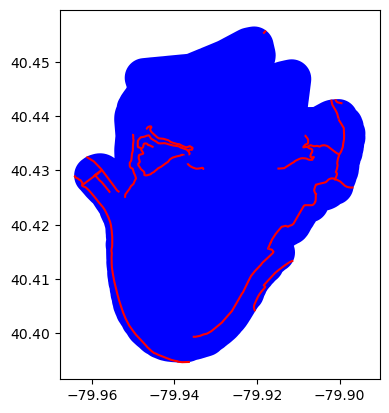

In [91]:
fig,ax=plt.subplots()
study_area_gdf.plot(ax=ax, color='blue')
gdf_trails.plot(ax=ax, color='red')

In [92]:
# filter edges to remove those with a speed limit > 35
all_e = list(edges_bike.keys())
e_remove = [e for e in all_e if edges_bike[e]['speed_lim'] > 35]
for e in e_remove:
    del edges_bike[e]

# convert to proper form for nx
nodes_bike_nx = list(zip(nidmap_bike.keys(), nidmap_bike.values()) )   
# only select a subset of edge attributes
for k in edges_bike.keys():
    attr = edges_bike[k]
    attr_subset = {c: attr[c] for c in ('st_name', 'oneway', 'geometry', 'length_m', 'bikeway_type', 'bikelane_id')}
    edges_bike[k] = attr_subset
edges_bike_nx = list(zip(list(zip(*edges_bike.keys()))[0], list(zip(*edges_bike.keys()))[1], edges_bike.values()))

# create nx graph object, complete with nodes (defined by position) and edges (defined by any selected
# attributes in street centerline file)
G_bike = nx.DiGraph()
G_bike.add_nodes_from(nodes_bike_nx)
G_bike.add_edges_from(edges_bike_nx)